In [134]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
class Point:
    """
    Create a point in space."""
    def __init__(self,x,y, mass=1.0,vx=0,vy=0, acc_x=0, acc_y=0):
        """
        Each point will have:
        mass (default 1.0),
        vx = velocity x_component (default = 0),
        vy = velocity y_component (default = 0),
        acc_x = acceleration x_component (default = 0),
        acc_y = acceleration y_component (default = 0)"""
        self.x = x
        self.y = y
        self.mass = mass
        self.vx = vx
        self.vy = vy
        self.acc_x = acc_x
        self.acc_y = acc_y
    
    def update_position(self, quadtree,dt):
        """Updates the position of the point based 
        on the Barnes-Hut algorithm
        quadtree = Quadtree object,
        dt = unit time
        """
        
        # Calculate the net force on the point
        force_x, force_y = quadtree.calculate_force(self)
        # Update the position
        self.vx += force_x / self.mass
        self.vy += force_y / self.mass
        self.x += self.vx*dt
        self.y += self.vy*dt
        
    def find_stable_orbital_velocity(self, central_mass, g_const):
        """
        Find the stable orbital velocity for the point"""
        G = g_const
        r = math.sqrt((self.x ** 2) + (self.y ** 2)) # distance between the point and central mass
        velocity = math.sqrt((G * central_mass) / r)
        self.vx = velocity * (self.x / r)
        self.vy = velocity * (self.y / r)
        
        
class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def intersects(self,other):
        """Does the other Rectangle object intersect with this one?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def show(self, axis,color='black'):
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        
        

class Quadtree:

    def __init__(self,boundary, G, n = 1, theta_=1):
        """
        Creates a Quadtree:
        boundary: Rectangle instance
        n = capacity
            choosing n = 1, i.e. if particle number crosses 1 than sub-divide
        G = gravitational constant
        theta_ = barnes hut algo theta (default value = 1)"""
        self.boundary = boundary

        # choosing capacity(n) = 1, i.e. if particle number crosses 1 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []
        self.quads = [None, None, None, None]
        self.divided = False
        self.mass = 0.0
        self.G = G
        self.theta_ = theta_
        self.center_of_mass_x = 0.0
        self.center_of_mass_y = 0.0

    def subdivide(self):
        """
        Subdivides the region into four parts"""
        #print("Subdividing region: ", self.boundary.x, self.boundary.y, self.boundary.w, self.boundary.h)
        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2, y - h/2, w, h)
        self.quads[0] = Quadtree(ne, self.capacity)
        nw = Rectangle(x - w/2, y - h/2, w, h)
        self.quads[1] = Quadtree(nw, self.capacity)
        se = Rectangle(x + w/2, y + h/2, w, h)
        self.quads[2] = Quadtree(se, self.capacity)
        sw = Rectangle(x - w/2, y + h/2, w, h)
        self.quads[3] = Quadtree(sw, self.capacity)
        self.divided = True

        for point in self.points:
            for quad in self.quads:
                if quad.insert(point):
                    break
        self.points = []
        
    
    # insert function from chatgpt (18/01/2023 - Wed)
    def insert(self, point):
        """Inserts a point into the Quadtree"""
        if self.divided:
            for quad in self.quads:
                if quad.insert(point):
                    return True
        if not self.boundary.contains(point):
            return False
        threshold = 1
        if len(self.points) < self.capacity or self.boundary.w < threshold:
            self.points.append(point)
            self.mass += point.mass
            self.center_of_mass_x += point.mass * point.x
            self.center_of_mass_y +=  point.mass * point.y
            return True
        else:
            if not self.divided:
                self.subdivide()
            for quad in self.quads:
                if quad.insert(point):
                    return True
        
        
    def center_of_mass(self):
        return self.center_of_mass_x/self.mass, self.center_of_mass_y/self.mass
    
    
    
    
    def calculate_force(self, point):
        """Calculates the net force on the point"""
        if self.mass == 0:
            return 0, 0
        if not self.divided:
            return self._calculate_force_on_point(point)
        else:
            if self._should_use_approximation(point):
                return self._calculate_force_on_point_approximation(point)
            else:
                force_x, force_y = 0, 0
                for quad in self.quads:
                    fx, fy = quad.calculate_force(point)
                    force_x += fx
                    force_y += fy
                return force_x, force_y

    def _calculate_force_on_point(self, point):
        """Calculates the force on the point due to all other points in the quadtree"""
        force_x, force_y = 0, 0
        for other_point in self.points:
            if other_point != point:
                dx = other_point.x - point.x
                dy = other_point.y - point.y
                r = (dx ** 2 + dy ** 2) ** 0.5
                if r == 0:
                    continue
                force = self.G * point.mass * other_point.mass / r ** 2
                force_x += force * dx / r
                force_y += force * dy / r
        return force_x, force_y
    
    def _calculate_force_on_point_approximation(self, point):
        """Calculates the force on the point due to the center of mass of the quadtree"""
        dx = self.center_of_mass_x - point.x
        dy = self.center_of_mass_y - point.y
        r = (dx ** 2 + dy ** 2) ** 0.5
        if r == 0:
            return 0, 0
        force = self.G * point.mass * self.mass / r ** 2
        return force * dx / r, force * dy / r
    
    def _should_use_approximation(self, point):
        """Determines whether to use the approximation or not"""
        
        r = ((point.x - self.center_of_mass_x)**2 + (point.y - self.center_of_mass_y)**2)**0.5
        return self.boundary.w / r > self.theta_


        

    def __len__(self):
        """Return the number of points in the quadtree."""

        npoints = len(self.points)
        if self.divided:
            npoints += len(self.quads[0])+len(self.quads[1])+len(self.quads[2])+len(self.quads[3])
        return npoints


    def check_collision(self):
        # check if self.divided
        # check the distance
        # less than prob than merge
        print(f'Number of points:{len(self)}')
        self.points = []
        
        if self.divided:
            pass

    def get_points(self):
        n = self.points
        if self.divided:
            n.append(self.northeast.points)
            n.append(self.northwest.points)
            n.append(self.southeast.points)
            n.append(self.southwest.points)


    def clear(self):
        """
        Clears the quadtree by resetting all points and sub-quadrants
        """
        self.points = []
        self.mass = 0.0
        self.center_of_mass_x = 0
        self.center_of_mass_y = 0
        self.divided = False
        self.quads = [None, None, None, None]
        
    def show(self, axis):
        self.boundary.show(axis)
        if self.divided:
            for quad in self.quads:
                quad.show(axis)
        
        


In [114]:
# specs of Rectangle (the main boundary):
width = 400
height = 400
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x,center_y,width,height)

# New points
points = []

# black hole at center
points.append(Point(center_x,center_y, mass= 5000,vx=0,vy=0))

# rogue: black hole:
rogue_x = center_x + width*0.25
rogue_y = center_y + height*0.25
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,mass=3500,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(200):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-10,0)
    thetav = np.random.normal(loc=-4,scale=1) if abs(x) <3 and abs(y) <3 else np.random.normal(-1,1)
    vx,vy = get_cart_coords_vel(rv,-10,r,theta)
    
    mass = np.random.randint(30,300)
    points.append(Point(x+rogue_x,y+rogue_y,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(500):
    r = np.random.uniform(1,70)
    theta = i*360/500
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-100,-90)
    thetav =-35 if abs(x) <3 and abs(y) <3 else -1
    #thetav = 0
    rv= 0
    vx,vy = get_cart_coords_vel(rv,thetav,r,theta)
    
    mass = np.random.randint(2,300)
    
    thetav = np.sqrt(150/r)
    points.append(Point(x+center_x,y+center_y,mass=mass,vx=vx,vy=vy))

    
# initialize the quadtree and the points list
qt = Quadtree(boundary,n=1, G=1, theta_=1)
for p in points:
    qt.insert(p)

# in the main loop
for time in range(500):
    plt.figure(figsize=(7,7))
    ps = []
    qt.clear()
    # clear the quadtree before inserting the new positions of the points
    for p in points:
        
        # wrap around when the particle goes out of bounds
        #wrap_point(p)
        
        # update the position of the point using the Barnes-Hut algorithm
        p.update_position(qt,dt=0.001)
        
        # insert the updated position of the point into the quadtree
        qt.insert(p)
        
        ps.append([p.x,p.y])
    ps = np.array(ps)
    plt.scatter(ps[:,0],ps[:,1],s=1,alpha=0.5,c='white')
    plt.xlim(-width*0.1, width*1.1)
    plt.ylim(-height*0.1, height*1.1)
    #plt.savefig("C:/Users/astro/Documents/GitHub/Orbital-simulations/animation_dump/"+str(time)+'.png')
    plt.show()
    print(f"frame: {time}/500")   
    clear_output(wait=True)

KeyboardInterrupt: 

<Figure size 504x504 with 0 Axes>

In [120]:
def get_cart_coords(r,theta):
    """returns x,y"""
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))

def get_cart_coords_vel(rv, thetav, r, theta):
    vx = rv*np.cos(np.deg2rad(theta)) - r*np.sin(np.deg2rad(theta))*thetav
    vy = rv*np.sin(np.deg2rad(theta)) + r*np.cos(np.deg2rad(theta))*thetav
    return vx, vy

In [135]:
def barnes_hut_sim(points, _wrap_points=False, dt=1, g_const=0, theta=1, save_to_video = False, plot = True):
    """
    Output: Refreshing plot of points being simulated using Barnes-Hut Algorithm.
    
    points = A list of "Point class" objects.
    
    _wrap_points = Wraps the points if they go out of bound.
    
    
    """
    
    
    def wrap_point(p):
        """
        Wraps the points such that they don't leave the boundary.
        """
        # wrap around when the particle goes out of bounds
        if p.x > width:
            p.x -= width
        elif p.x < 0:
            p.x += width
        if p.y > height:
            p.y -= height
        elif p.y < 0:
            p.y += height
    
    # initialize the quadtree and the points list
    qt = Quadtree(boundary,n=1, G=g_const, theta_=theta)
    for p in points:
        qt.insert(p)

    # for saving video
    frames = []
    
    # in the main loop
    for time in range(100):
        fig, ax = plt.subplots(figsize=(10,10))
        # Plot stars list
        ps = []
        
        # Clear all the points in the tree:
        qt.clear()
        # clear the quadtree before inserting the new positions of the points
        
        for p in points:

            # wrap around when the particle goes out of bounds
            if _wrap_points:
                wrap_point(p)

            # update the position of the point using the Barnes-Hut algorithm
            p.update_position(qt,dt=dt)

            # insert the updated position of the point into the quadtree
            qt.insert(p)
            
            # add stars for plotting
            ps.append([p.x,p.y])
        
        ps = np.array(ps)
        
        if plot:
            # Plot points/stars
            ax.scatter(ps[:,0],ps[:,1],s=1,alpha=0.5,c='white')
            ax.set_xlim(-width*0.1, width*1.1)
            ax.set_ylim(-height*0.1, height*1.1)
        # Convert the figure to a numpy array
        if save_to_video:
            fig.canvas.draw()
            data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
            data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(data)
        plt.show()
        print(f"frame: {time}/100")   
        clear_output(wait=True)
    if save_to_video:
        import imageio     
        imageio.mimsave(save_to_video, frames, 'MP4', fps=30)

KeyboardInterrupt: 

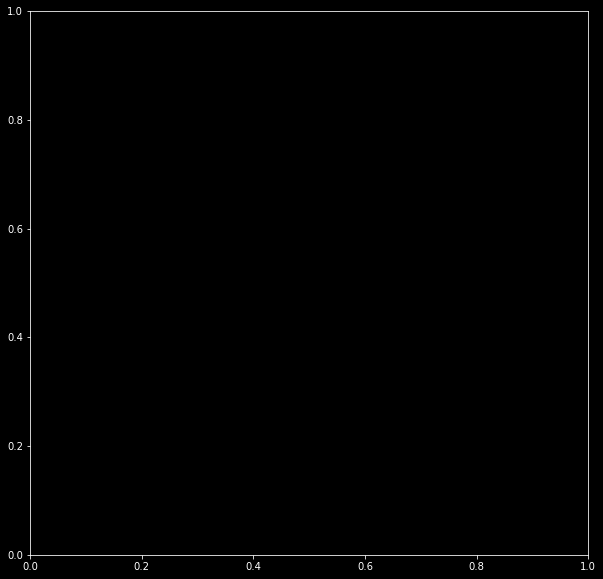

In [133]:
# specs of Rectangle (the main boundary):
width = 1200
height = 1200
center_x = width/2
center_y = height/2
boundary = Rectangle(center_x,center_y,width,height)

# New points
points = []

# black hole at center
points.append(Point(center_x,center_y, mass= 5000,vx=0,vy=0))

# rogue: black hole:
rogue_x = center_x + width*0.25
rogue_y = center_y + height*0.25
rogue_vx = 0
rogue_vy = 0
points.append(Point(rogue_x,rogue_y,mass=3500,vx=rogue_vx,vy=rogue_vy))

#stars for rogue black hole
for i in range(200):
    r = np.random.uniform(0,30)
    theta = i*360/50
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-10,0)
    thetav = np.random.normal(loc=-40,scale=1) if abs(x) <3 and abs(y) <3 else np.random.normal(-1,1)
    vx,vy = get_cart_coords_vel(0,0,r,theta)
    
    mass = np.random.randint(300,1000)
    points.append(Point(x+rogue_x,y+rogue_y,mass=mass,vx=vx+rogue_vx,vy=vy+rogue_vy))


# stars for center black hole
for i in range(500):
    r = np.random.uniform(1,70)
    theta = i*360/80
    x,y = get_cart_coords(r, theta)
    
    rv = np.random.uniform(-100,-90)
    thetav =-350 if abs(x) <30 and abs(y) <30 else -10
    #thetav = 0
    rv= -10
    vx,vy = get_cart_coords_vel(0,0,r,theta)
    
    mass = np.random.randint(200,2000)
    
    thetav = np.sqrt(150/r)
    points.append(Point(x+center_x,y+center_y,mass=mass,vx=vx,vy=vy))

    
##############
#####RUNNING THE SIMULATION #########################
barnes_hut_sim(points,
               dt=0.00111,
               g_const=0,
               theta=0.1,
               _wrap_points=False,
               save_to_video='barnes_hut_1.mp4',
               plot=True)

In [90]:
pip install imageio-ffmpeg

     --------------------------------------- 22.6/22.6 MB 36.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


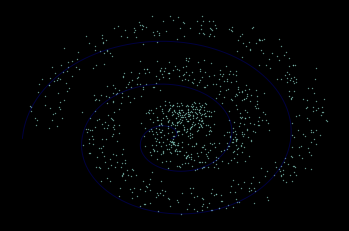

In [60]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')  
fig, ax = plt.subplots()

# Generate x and y coordinates for the spiral pattern
theta = np.linspace(0, 5 * np.pi, 1000)
r = np.linspace(0, 1, 1000)
x = r * np.cos(theta)
y = r * np.sin(theta)

x_init = []
y_init = []

for i in range(1000):
    x_init.append(x[i] + 0.25*np.random.rand())
    y_init.append(y[i] + 0.25*np.random.rand())

# Plot the spiral pattern
ax.plot(x,y,color='blue',linewidth=1,alpha=0.25)
ax.scatter(x_init, y_init, s=0.1)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.show()

<ipython-input-62-f7ca8dd2858f>:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')


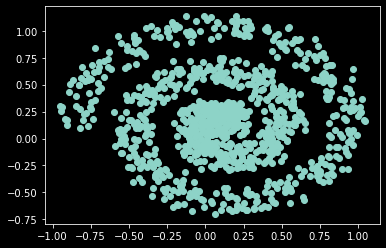

In [62]:
fig, ax = plt.subplots()
ax.scatter(x_init, y_init)

# Convert the figure to a numpy array
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [65]:
data.shape

(288, 432, 3)